In [2]:
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import multiprocessing as mp

df = pd.read_csv('Combined_valid_data.csv')
df.head()

,E_homo,E_lumo,KS_gap,CAN_SMILES,MW
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501


In [3]:
#similarity score calculation
# Create two sample molecules
mol1 = Chem.MolFromSmiles('c1ccccc1')  # benzene
mol2 = Chem.MolFromSmiles('c1ccccc1O')  # phenol

# Generate fingerprints for the molecules
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2)
fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2)

# Calculate Tanimoto similarity
tanimoto_sim = DataStructs.TanimotoSimilarity(fp1, fp2)
print(tanimoto_sim)

0.2727272727272727


In [10]:
def compute_fingerprints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2)
    else:
        return None

def compute_similarity(args):
    fp1, fp2 = args
    if fp1 is not None and fp2 is not None:
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    else:
        return 0

def add_tanimoto_similarity_columns(smiles_data):
    pool = mp.Pool(mp.cpu_count())
    fingerprints = pool.map(compute_fingerprints, smiles_data['CAN_SMILES'])
    smiles_data['Fingerprint'] = fingerprints

    results = []
    for i in range(len(fingerprints)):
        similarities = pool.map(compute_similarity, [(fingerprints[i], fp) for fp in fingerprints[i+1:]])
        if similarities:
            max_similarity = max(similarities)
            max_index = similarities.index(max_similarity) + i + 1
            results.append((max_similarity, smiles_data.iloc[max_index]['CAN_SMILES']))
        else:
            results.append((0, None))

    smiles_data['Highest Tanimoto Score'], smiles_data['Most Similar SMILES'] = zip(*results)
    pool.close()
    pool.join()
    return smiles_data

updated_df = add_tanimoto_similarity_columns(df)
print(updated_df.shape)
updated_df.to_csv('similarity_score_dataset.csv', index=False)

KeyboardInterrupt: 

In [13]:
df = pd.read_csv('similarity_score_dataset.csv')
df.head()

,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,Fingerprint,Highest Tanimoto Score,Most Similar SMILES
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.733333,CC#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.739130,Cc1csc2-c3c(C(=O)c12)c(cs3)c1c2sccc2cc2c1ccs2
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.777778,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=O)c2c1csc2
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.714286,O=N(=O)c1cc2c(sc(c2cc1N(=O)=O)C(F)(F)F)c1csc2-...
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.759259,Cc1csc2-c3c(C(=O)c12)c(cs3)c1cc(ccc1N(=O)=O)c1...


In [32]:
def find_most_similar_molecule(smiles_data, target_smiles):
    # Convert target SMILES to RDKit molecule and fingerprint
    target_molecule = Chem.MolFromSmiles(target_smiles)
    target_fingerprint = AllChem.GetMorganFingerprintAsBitVect(target_molecule, radius=2)

    # Initialize variables to store the highest score and corresponding SMILES
    highest_score = 0
    most_similar_smiles = None

    # Iterate over each molecule in the dataset to find the highest similarity
    for i, row in smiles_data.iterrows():
        current_fingerprint = AllChem.GetMorganFingerprintAsBitVect(row['Molecule'], radius=2)
        similarity = DataStructs.TanimotoSimilarity(target_fingerprint, current_fingerprint)

        # Update highest score if the current similarity is greater
        if similarity > highest_score:
            highest_score = similarity
            most_similar_smiles = row['CAN_SMILES']

    return highest_score, most_similar_smiles


df['Molecule'] = df['CAN_SMILES'].apply(Chem.MolFromSmiles) 
target_smiles = df.iloc[-1,:]['CAN_SMILES']
score, similar_smiles = find_most_similar_molecule(df, target_smiles)
print("Highest Tanimoto Score:", score)
print("Most Similar SMILES:", similar_smiles)

C:\Users\akepati\AppData\Local\Temp\ipykernel_7928\2440006362.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Molecule'] = df['CAN_SMILES'].apply(Chem.MolFromSmiles)


Highest Tanimoto Score: 1.0
Most Similar SMILES: COc1cc(sc1c1sc(cc1OC)c1n(C)c(c(c1SC)SC)c1ncc(c2c1nn(n2)C)c1n(C)cc(c1SC)SC)c1n(C)c(c(c1SC)SC)c1cnc(c2c1nn(n2)C)c1n(C)c(c(c1SC)SC)c1cc(c(s1)c1sccc1OC)OC	



In [41]:
missing_row['Highest Tanimoto Score'] = 1
missing_row['Most Similar SMILES'] = similar_smiles
df = pd.concat([df,missing_row],ignore_index=True)
df.tail()

C:\Users\akepati\AppData\Local\Temp\ipykernel_7928\1594813898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_row['Highest Tanimoto Score'] = 1
C:\Users\akepati\AppData\Local\Temp\ipykernel_7928\1594813898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_row['Most Similar SMILES'] = similar_smiles


,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,Fingerprint,Highest Tanimoto Score,Most Similar SMILES,Molecule
94330,-5.305322,-2.359499,2.945823,CSc1c(c2cc(c(s2)c2sc(cc2C)c2c(SC)c(c(n2C)c2ncc...,1335.99,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.723684,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...
94331,-5.396725,-2.501978,2.894747,CSc1c(c2cc(c(s2)c2sc(cc2F)c2c(SC)c(c(n2C)c2ncc...,1351.85,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.782609,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...
94332,-5.117781,-2.422929,2.694852,CSc1c(c2ccc(o2)c2ccc(o2)c2c(SC)c(c(n2C)c2ncc(c...,1215.63,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.530120,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...
94333,-4.859328,-2.344479,2.514849,COc1cc(sc1c1sc(cc1OC)c1n(C)c(c(c1SC)SC)c1ncc(c...,1399.99,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.760563,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...
94334,-5.403637,-2.361159,3.042478,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,1464.25,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,1.000000,COc1cc(sc1c1sc(cc1OC)c1n(C)c(c(c1SC)SC)c1ncc(c...,<rdkit.Chem.rdchem.Mol object at 0x000001DA913...


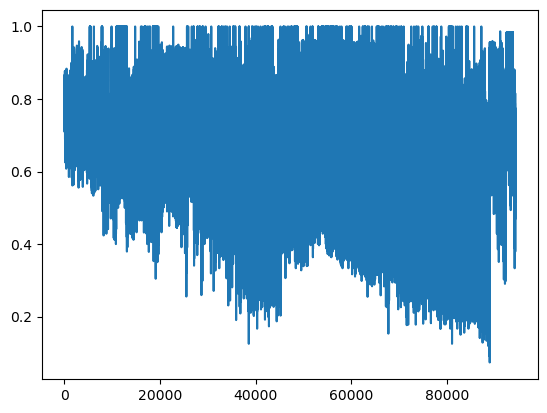

In [36]:
import matplotlib.pyplot as plt
plt.plot(df['Highest Tanimoto Score'])

In [46]:
count = 0
for i in df['Highest Tanimoto Score']:
    if i<=0.5:
        count+=1
print(count)

17786


In [47]:
df

,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,Fingerprint,Highest Tanimoto Score,Most Similar SMILES,Molecule
0,-5.170170,-2.288480,2.881690,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.733333,CC#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...
1,-5.292620,-2.476240,2.816380,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.739130,Cc1csc2-c3c(C(=O)c12)c(cs3)c1c2sccc2cc2c1ccs2,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...
2,-5.306220,-2.400050,2.906170,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.777778,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=O)c2c1csc2,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...
3,-5.991950,-2.911620,3.080330,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.714286,O=N(=O)c1cc2c(sc(c2cc1N(=O)=O)C(F)(F)F)c1csc2-...,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...
4,-5.319830,-2.440860,2.878970,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.759259,Cc1csc2-c3c(C(=O)c12)c(cs3)c1cc(ccc1N(=O)=O)c1...,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...
...,...,...,...,...,...,...,...,...,...
94330,-5.305322,-2.359499,2.945823,CSc1c(c2cc(c(s2)c2sc(cc2C)c2c(SC)c(c(n2C)c2ncc...,1335.990,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.723684,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...
94331,-5.396725,-2.501978,2.894747,CSc1c(c2cc(c(s2)c2sc(cc2F)c2c(SC)c(c(n2C)c2ncc...,1351.850,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.782609,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...
94332,-5.117781,-2.422929,2.694852,CSc1c(c2ccc(o2)c2ccc(o2)c2c(SC)c(c(n2C)c2ncc(c...,1215.630,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.530120,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...
94333,-4.859328,-2.344479,2.514849,COc1cc(sc1c1sc(cc1OC)c1n(C)c(c(c1SC)SC)c1ncc(c...,1399.990,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.760563,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...


In [ ]:
for i in df['CAN_SMILES']:
    if i in df['Most Similar SMILES']:
        df['Similar_Homo'] = 

In [54]:
similar_properties = df.merge(df[['CAN_SMILES', 'E_homo', 'E_lumo']], left_on='Most Similar SMILES', right_on='CAN_SMILES', suffixes=('', '_similar'))

# Adding new columns to the original DataFrame
df['similar_homo'] = similar_properties['E_homo_similar']
df['similar_lumo'] = similar_properties['E_lumo_similar']
df

,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,Fingerprint,Highest Tanimoto Score,Most Similar SMILES,Molecule,similar_homo,similar_lumo
0,-5.170170,-2.288480,2.881690,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.733333,CC#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...,-4.985130,-2.223170
1,-5.292620,-2.476240,2.816380,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.739130,Cc1csc2-c3c(C(=O)c12)c(cs3)c1c2sccc2cc2c1ccs2,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...,-5.273570,-2.435420
2,-5.306220,-2.400050,2.906170,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.777778,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=O)c2c1csc2,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...,-5.564730,-2.587800
3,-5.991950,-2.911620,3.080330,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.714286,O=N(=O)c1cc2c(sc(c2cc1N(=O)=O)C(F)(F)F)c1csc2-...,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...,-6.168820,-3.126590
4,-5.319830,-2.440860,2.878970,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.759259,Cc1csc2-c3c(C(=O)c12)c(cs3)c1cc(ccc1N(=O)=O)c1...,<rdkit.Chem.rdchem.Mol object at 0x000001D085C...,-6.168820,-3.126590
...,...,...,...,...,...,...,...,...,...,...,...
94330,-5.305322,-2.359499,2.945823,CSc1c(c2cc(c(s2)c2sc(cc2C)c2c(SC)c(c(n2C)c2ncc...,1335.990,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.723684,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...,-4.579404,-3.044736
94331,-5.396725,-2.501978,2.894747,CSc1c(c2cc(c(s2)c2sc(cc2F)c2c(SC)c(c(n2C)c2ncc...,1351.850,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.782609,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...,-5.424508,-3.028110
94332,-5.117781,-2.422929,2.694852,CSc1c(c2ccc(o2)c2ccc(o2)c2c(SC)c(c(n2C)c2ncc(c...,1215.630,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.530120,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...,-4.776442,-3.005171
94333,-4.859328,-2.344479,2.514849,COc1cc(sc1c1sc(cc1OC)c1n(C)c(c(c1SC)SC)c1ncc(c...,1399.990,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.760563,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,<rdkit.Chem.rdchem.Mol object at 0x000001DC071...,-5.476427,-3.111214


In [56]:
df = df.drop(['Fingerprint', 'Molecule'], axis=1)
df

,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,Highest Tanimoto Score,Most Similar SMILES,similar_homo,similar_lumo
0,-5.170170,-2.288480,2.881690,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,0.733333,CC#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,-4.985130,-2.223170
1,-5.292620,-2.476240,2.816380,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,0.739130,Cc1csc2-c3c(C(=O)c12)c(cs3)c1c2sccc2cc2c1ccs2,-5.273570,-2.435420
2,-5.306220,-2.400050,2.906170,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,0.777778,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=O)c2c1csc2,-5.564730,-2.587800
3,-5.991950,-2.911620,3.080330,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,0.714286,O=N(=O)c1cc2c(sc(c2cc1N(=O)=O)C(F)(F)F)c1csc2-...,-6.168820,-3.126590
4,-5.319830,-2.440860,2.878970,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,0.759259,Cc1csc2-c3c(C(=O)c12)c(cs3)c1cc(ccc1N(=O)=O)c1...,-6.168820,-3.126590
...,...,...,...,...,...,...,...,...,...
94330,-5.305322,-2.359499,2.945823,CSc1c(c2cc(c(s2)c2sc(cc2C)c2c(SC)c(c(n2C)c2ncc...,1335.990,0.723684,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,-4.579404,-3.044736
94331,-5.396725,-2.501978,2.894747,CSc1c(c2cc(c(s2)c2sc(cc2F)c2c(SC)c(c(n2C)c2ncc...,1351.850,0.782609,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,-5.424508,-3.028110
94332,-5.117781,-2.422929,2.694852,CSc1c(c2ccc(o2)c2ccc(o2)c2c(SC)c(c(n2C)c2ncc(c...,1215.630,0.530120,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,-4.776442,-3.005171
94333,-4.859328,-2.344479,2.514849,COc1cc(sc1c1sc(cc1OC)c1n(C)c(c(c1SC)SC)c1ncc(c...,1399.990,0.760563,CSc1cc(sc1c1sc(cc1SC)c1c(SC)c(c(n1C)c1ncc(c2c1...,-5.476427,-3.111214


In [57]:
df.to_csv('Similarity_SMILES.csv',index=False)

In [58]:
df.head()

,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,Highest Tanimoto Score,Most Similar SMILES,similar_homo,similar_lumo
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,0.733333,CC#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,-4.98513,-2.22317
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,0.739130,Cc1csc2-c3c(C(=O)c12)c(cs3)c1c2sccc2cc2c1ccs2,-5.27357,-2.43542
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,0.777778,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=O)c2c1csc2,-5.56473,-2.58780
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,0.714286,O=N(=O)c1cc2c(sc(c2cc1N(=O)=O)C(F)(F)F)c1csc2-...,-6.16882,-3.12659
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,0.759259,Cc1csc2-c3c(C(=O)c12)c(cs3)c1cc(ccc1N(=O)=O)c1...,-6.16882,-3.12659
